# Souls Randomizer

In [1]:
import numpy as np
import pandas as pd
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (32, 18)

In [3]:
full_path = r'Y:\SteamLibrary\steamapps\common\DARK SOULS III\Game\fog\spoiler_logs\2021-03-03_15.38.28_log_991041151_66353.txt'

# full_path = r'Y:\SteamLibrary\steamapps\common\DARK SOULS III\Game\fog\spoiler_logs\2021-03-02_16.59.07_log_2141935386_66353.txt'

In [4]:
class FogRemover():
    def __init__(self, full_path):
        self.full_path = full_path
    
    def process(self):
        # Read in .txt to 
        doc = open(self.full_path, 'r').readlines()
        # Remove the header, which are the first 6 lines.
        # Remove the tail, which can be searched
        stop_idx = np.nonzero([re.match('Finished', line) for line in doc])[0][0]
        doc = doc[6:stop_idx]
        # Remove anything else manually
        remove_idx = np.nonzero([re.match('>', line) for line in doc])[0][0]
        del doc[remove_idx]

        # Extract specific lines
        key_areas = np.nonzero([re.match('\S', line) for line in doc])[0]
        warps_preexisting = np.nonzero([re.match('\s\sPre', line) for line in doc])[0]
        warps_random = np.nonzero([re.match('\s\sRan', line) for line in doc])[0]
        warps = np.sort(np.concatenate((warps_preexisting,warps_random)))

        # Further clean these lines
        zones = [doc[i].split(' (')[0] for i in key_areas]
        scaling = [re.findall(r'\d+',doc[i])[0] for i in key_areas]
        fog_gates = [doc[i][1:] for i in warps]

        # Generate dataframe
        all_zones = pd.DataFrame(zip(zones, scaling), columns=['Zone','Scaling'])

        # This is required for easily converting between zones in index numbers
        dictionary = pd.Series(all_zones.Zone.values, index=all_zones.index).to_dict()
        dictionary = {v:str(k) for k,v in dictionary.items()}

        # Finalize cleanup on fog gates
        cleaned_fog_gates = []
        ct = 0
        for gate in fog_gates:
            # Removes text between parens
            gate = re.sub("[\(\[].*?[\)\]]", "", gate)
            # Replaces zones with numbers
            gate = self.multiple_replace(dictionary, gate)
            # Find the numbers
            gate = re.findall(r'\d+',gate)
            if len(gate)>2:
                if not bool(re.search('also defeating Abyss Watchers', fog_gates[ct])):
                    print(f'Warning. Found more than 2 locations at index {ct}')
                    print(fog_gates[ct])
            gate = gate[:2]
            cleaned_fog_gates.append(gate)
            ct += 1

        fog_gates_transposed = list(map(list, zip(*cleaned_fog_gates)))
        fog_gates_from = fog_gates_transposed[0]
        fog_gates_to = fog_gates_transposed[1]
        fog_gates_from_str = [all_zones.Zone[int(idx)]for idx in fog_gates_from]
        fog_gates_to_str = [all_zones.Zone[int(idx)]for idx in fog_gates_to]
        
        # Generate dataframe
#         all_fog_gates = pd.DataFrame(zip(fog_gates_from_str, fog_gates_to_str, fog_gates_from, fog_gates_to, fog_gates), columns=['From','To','From_Index','To_Index','Full Text'])
        all_fog_gates = pd.DataFrame(zip(fog_gates_from_str, fog_gates_to_str, fog_gates), columns=['From','To','Full Text'])
        all_fog_gates['Random'] = [bool(re.match('\sRandom', i)) for i in all_fog_gates['Full Text']]

        # Build your graph
        G = nx.from_pandas_edgelist(all_fog_gates, 'From', 'To')        
        self.fog_gates = all_fog_gates
        self.zones = all_zones
        self.G = G
        
    def multiple_replace(self, dict, text):
      # Create a regular expression  from the dictionary keys
      regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

      # For each match, look-up corresponding value in dictionary
      return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 
    
    def search(self, query):
        mask1 = np.nonzero([re.search(query,zone) for zone in self.fog_gates.From])
        mask2 = np.nonzero([re.search(query,zone) for zone in self.fog_gates.To])
        mask = np.unique(np.sort(np.concatenate((mask1[0],mask2[0]))))
        return self.fog_gates.iloc[mask]
    
    def path(self, start, finish):
        locations = nx.dijkstra_path(self.G, start, finish)
        steps = []
        path = []
        print('Optimal Path:', locations, '\n')
        for i in range(len(locations)-1):
            steps.append([locations[i],locations[i+1]])
            _df = self.search(steps[i][0])
            _df = _df[((_df.From==locations[i])&(_df.To==locations[i+1])) | ((_df.To==locations[i]) & (_df.From==locations[i+1]))]
            path.append(_df)
        return(pd.concat(path))
    
    def plot(self, k=.1, iterations=1000, show=True, export=True, cmap='RdYlGn_r'):
        # Color
        zones = self.zones
        zones = zones.set_index('Zone')
        zones = zones.reindex(self.G.nodes())
        max_value = zones.Scaling.astype(int).max()
        zones['Scaling'] = [255*int(i)/max_value for i in zones.Scaling]
        # Fruchterman Reingold
        fig = nx.draw(self.G, with_labels=True, node_size=200,  
                      pos=nx.fruchterman_reingold_layout(self.G, k=k, iterations=iterations), 
                      node_shape='o',
                      font_size=8,
                      node_color=zones['Scaling'].astype(int),
                      cmap=plt.get_cmap(cmap))
        plt.title("Souls Randomizer Map")
        if export: plt.savefig('./tmp/test0.png')
        if show:
            plt.show()
        else:
            plt.close(fig)    

## Run examples

In [5]:
info = FogRemover(full_path)
info.process()

In [6]:
info.fog_gates.sample(5)

,From,To,Full Text,Random
49,immediately after Pontiff Sulyvahn,"Aldrich, Devourer of Gods","Random: From immediately after Pontiff Sulyvahn (between the hallway immediately after Pontiff and Anor Londo) to Aldrich, Devourer of Gods (between the right elevator after Aldrich and Aldrich)\n",True
67,Cathedral of the Deep,Catacombs of Carthus,Random: From Cathedral of the Deep Start (between the path to Cathedral and Crystal Sage) to Catacombs of Carthus (between the stairs after Abyss Watchers and Catacombs)\n,True
2,Catacombs Wolnir Room,before the bridge into Irithyll,Preexisting: From Catacombs Wolnir Room to before the bridge into Irithyll (after Wolnir)\n,False
54,Farron Keep,Road of Sacrifices,Preexisting: From Farron Keep to Road of Sacrifices (ascending from Farron Keep)\n,False
53,Irithyll Distant Manor,Road of Sacrifices,Random: From Irithyll Distant Manor (between Distant Manor and Irithyll) to Road of Sacrifices (between Crystal Sage and Road of Sacrifices)\n,True


In [7]:
info.zones.sample(5)

,Zone,Scaling
76,before Twin Princes,100
81,Iudex Gundyr,349
75,Grand Archives Bonfire,130
52,Catacombs of Carthus,131
35,Ancient Wyvern Arena,59


In [8]:
info.search('Archdragon')

,From,To,Full Text,Random
38,Cathedral of the Deep,Archdragon Peak Start,Random: From Cathedral of the Deep (warp to Ariandel) to Archdragon Peak Start (warp to Archdragon Peak)\n,True
50,Central Archdragon Peak,"Aldrich, Devourer of Gods","Random: From Central Archdragon Peak (between below Nameless King and below the bell) to Aldrich, Devourer of Gods (between the left elevator after Aldrich and Aldrich)\n",True
55,Archdragon Peak Start,gate before Ancient Wyvern,Preexisting: From Archdragon Peak Start to gate before Ancient Wyvern (opening the gate)\n,False
56,Archdragon Peak Start,Sister Friede,Random: From Archdragon Peak Start (between shortcut elevator and the start of Archdragon Peak) to Sister Friede (between Sister Friede and Ariandel Chapel)\n,True
60,Ancient Wyvern Arena,Central Archdragon Peak,Preexisting: From Ancient Wyvern Arena to Central Archdragon Peak (warp after defeating Ancient Wyvern)\n,False
73,Central Archdragon Peak,before Nameless King,Preexisting: From Central Archdragon Peak to before Nameless King (dropping down past the bell)\n,False
74,Central Archdragon Peak,Central Archdragon Peak,Preexisting: From Central Archdragon Peak to Central Archdragon Peak using Path of the Dragon (using Path of the Dragon)\n,False
75,Central Archdragon Peak,door to Ancient Wyvern Arena,Preexisting: From Central Archdragon Peak to door to Ancient Wyvern Arena (the door between the Ancient Wyvern chain axe serpent and Dragonkin Mausoleum)\n,False
76,Central Archdragon Peak,above Dorhys in Irithyll,Random: From Central Archdragon Peak (between top of Archdragon shortcut elevator and Dragonkin Mausoleum) to above Dorhys in Irithyll (between the area above Dorhys' Gnawing and the illusory railing)\n,True
77,Central Archdragon Peak,Grand Archives,Random: From Central Archdragon Peak (between area overlooking Ancient Wyvern Arena and stairs around Dragonkin Mausoleum) to Grand Archives (at the top of the shortcut elevator right outside Twin Princes)\n,True


In [9]:
info.path("Greirat's Cell", 'Grand Archives')

Optimal Path: ["Greirat's Cell", 'High Wall', 'Pontiff Sulyvahn', 'above Pontiff', 'Twin Princes', 'Slave Knight Gael', 'Central Archdragon Peak', 'Grand Archives'] 



,From,To,Full Text,Random
127,High Wall,Greirat's Cell,"Preexisting: From High Wall to Greirat's Cell (using Cell Key, an item from Dancer of the Boreal Valley)\n",False
30,High Wall,Pontiff Sulyvahn,Random: From High Wall (between Vordt and High Wall) to Pontiff Sulyvahn (between Pontiff and Central Irithyll)\n,True
31,above Pontiff,Pontiff Sulyvahn,Preexisting: From above Pontiff to Pontiff Sulyvahn (taking the elevator shortcut down)\n,False
104,Twin Princes,above Pontiff,Random: From Twin Princes shortcut elevator bottom (between bottom of Twin Princes shortcut elevator and Lothric Castle) to above Pontiff (between above Pontiff and Anor Londo)\n,True
98,Slave Knight Gael,Twin Princes,Random: From Slave Knight Gael (between Gael's arena and Filianore's Rest) to Twin Princes shortcut elevator top (at the top of the shortcut elevator right outside Twin Princes)\n,True
80,Central Archdragon Peak,Slave Knight Gael,Random: From Central Archdragon Peak (between below Nameless King and Dragonkin Mausoleum) to Slave Knight Gael (between Shira's invasion area and Gael's arena)\n,True
77,Central Archdragon Peak,Grand Archives,Random: From Central Archdragon Peak (between area overlooking Ancient Wyvern Arena and stairs around Dragonkin Mausoleum) to Grand Archives (at the top of the shortcut elevator right outside Twin Princes)\n,True


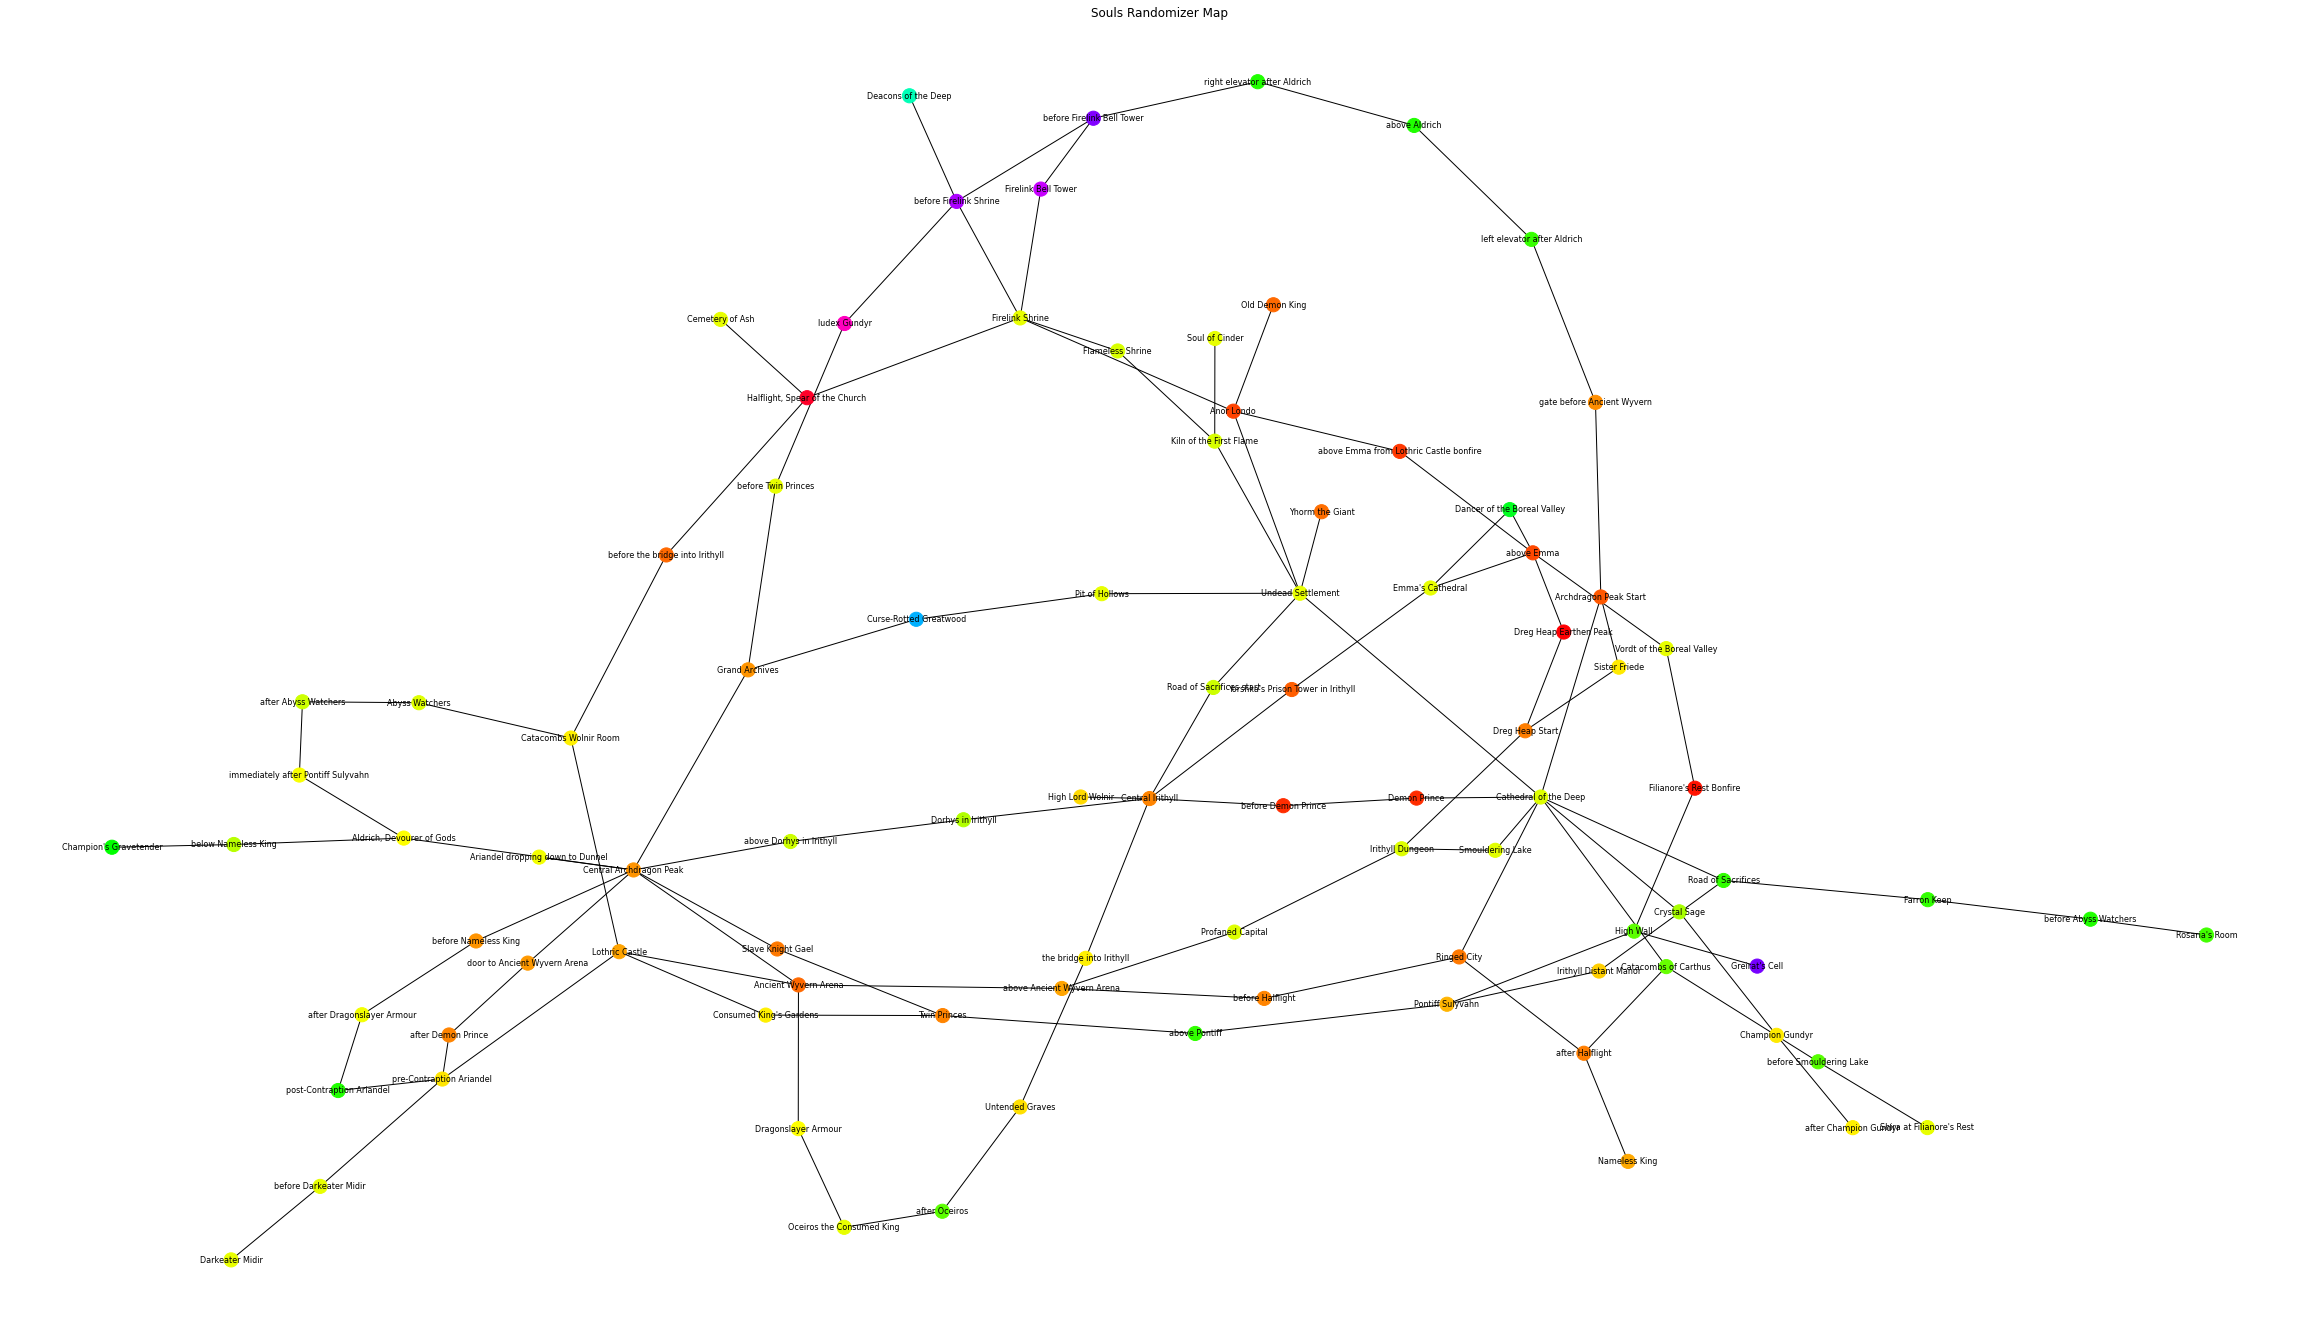

In [10]:
info.plot(cmap='gist_rainbow')
# For colorblind settings, pass in cmap='binary'